# Strategy

In this notebook, we attempt to train an inverse dynamics model (IDM). In Reinforcement Learning parlance, an IDM learns to predict $a_t$ given $s_t$ and $s_{t+1}$. In our case, we have access to the MetaDrive simulator and the Waymo dataset. We want to predict the action the car should take in MetaDrive so that the successor state in the simulator is as close as possible to the successor state in the Waymo dataset.

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
import os
import lzma
import numpy as np
import random
import gymnasium as gym
import typing
from metadrive import MetaDriveEnv

from utils.env import State, Observation, Action, state_batch_to_tensor, action_batch_to_tensor, obs_batch_to_tensor, get_metadrive_state, next_state, normalize_angle
from utils.metadrive_model import MetadriveModel
from utils.model_utils import set_lr, deviceof
from utils.in_memory_scenario_env import InMemoryScenarioEnv
from utils.loader import getFiles
from utils.waymo_loader import extract_trajectory_file, extract_scenarios_file


from torch.utils.data import TensorDataset, DataLoader
import itertools
import matplotlib.pyplot as plt

# CHANGE ME: Set this to the path to the Waymo Open Dataset root directory
WAYMO_DATA_PATH = "~/data/waymo"

2023-09-02 12:54:57.158821: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-02 12:54:58.184471: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [93]:
file_iter = iter(getFiles(WAYMO_DATA_PATH))
trajectories: list[list[State]] = []

In [107]:
for file_path in file_iter:
    trajectories_in_file = extract_trajectory_file(file_path)
    trajectories.extend(trajectories_in_file)
    print(f"Loaded {len(trajectories_in_file)} trajectories from {file_path}.")

Loaded 87 trajectories from /home/fidgetsinner/data/waymo/training_20s.tfrecord-00027-of-01000.
Loaded 73 trajectories from /home/fidgetsinner/data/waymo/training_20s.tfrecord-00028-of-01000.
Loaded 64 trajectories from /home/fidgetsinner/data/waymo/training_20s.tfrecord-00029-of-01000.
Loaded 64 trajectories from /home/fidgetsinner/data/waymo/training_20s.tfrecord-00030-of-01000.
Loaded 57 trajectories from /home/fidgetsinner/data/waymo/training_20s.tfrecord-00031-of-01000.
Loaded 75 trajectories from /home/fidgetsinner/data/waymo/training_20s.tfrecord-00032-of-01000.
Loaded 76 trajectories from /home/fidgetsinner/data/waymo/training_20s.tfrecord-00033-of-01000.
Loaded 75 trajectories from /home/fidgetsinner/data/waymo/training_20s.tfrecord-00034-of-01000.
Loaded 72 trajectories from /home/fidgetsinner/data/waymo/training_20s.tfrecord-00035-of-01000.
Loaded 68 trajectories from /home/fidgetsinner/data/waymo/training_20s.tfrecord-00036-of-01000.
Loaded 61 trajectories from /home/fidget

KeyboardInterrupt: 

In [36]:
# pickle the trajectories
if not os.path.exists('./data/waymo/trajectories.pkl.xz'):
    with lzma.open('./data/waymo/trajectories.pkl.xz', 'wb') as f:
        pickle.dump(trajectories, f)

In [2]:
# unpickle and decompress
if "trajectories" not in locals():
    with lzma.open('./data/waymo/trajectories.pkl.xz', 'rb') as f:
        trajectories: list[list[State]] = pickle.load(f)

In [3]:
idm_data: list[Observation] = []
for states in trajectories:
    for i in range(len(states)-1):
        idm_data.append((states[i], states[i+1]))

# 90:10 train-validation split
random.seed(0)
random.shuffle(idm_data)
idm_train_data = idm_data[:int(len(idm_data)*0.9)]
idm_validation_data = idm_data[int(len(idm_data)*0.9):]

In [4]:
print("train data:", len(idm_train_data))
print("validation data:", len(idm_validation_data))

train data: 419886
validation data: 46654


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
mm = MetadriveModel().to(device)
mm.load_state_dict(torch.load('data/mm.pth'))

<All keys matched successfully>

Now that we have trained a neural network model of Metadrive through which we can backprop, training the IDM is easy.

In [30]:
# creates a model that attempts to predict the action given the current state and the next state
class InverseDynamicsModel(nn.Module):
    def __init__(self):
        super().__init__()
        # input shape: (batch_size, 4, 2)
        # output shape: (batch_size, 2)

        self.conv1 = nn.Conv1d(4, 2048, 2) # Bx4x2 -> Bx768x1
        self.fc1 = nn.Linear(2048, 1536) # Bx768 -> Bx768
        self.fc2 = nn.Linear(1536, 1024) # Bx768 -> Bx768
        self.fc3 = nn.Linear(1024, 768) # Bx768 -> Bx768
        self.fc4 = nn.Linear(768, 2) # Bx768 -> Bx2
    
    def forward(self, x: torch.Tensor):
        x = F.relu(self.conv1(x))
        x = torch.flatten(x, 1)        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        x = torch.clamp(x, -1, 1)
        return x

def idm_train_batch(
        mm: MetadriveModel,
        idm: InverseDynamicsModel,
        idm_optimizer: torch.optim.Optimizer,
        obs_tensor: torch.Tensor,
        s0_tensor: torch.Tensor,
        s1_tensor: torch.Tensor,
) -> float:
    device = deviceof(mm)
    assert deviceof(idm) == device

    obs_tensor = obs_tensor.to(device)
    s0_tensor = s0_tensor.to(device)
    s1_tensor = s1_tensor.to(device)

    idm_optimizer.zero_grad()

    pred_action = idm(obs_tensor)
    pred_s1 = mm(s0_tensor, pred_action)

    loss = F.mse_loss(pred_s1, s1_tensor)
    loss.backward()

    idm_optimizer.step()

    return float(loss.item())

In [31]:
idm_train_dataset = TensorDataset(
    obs_batch_to_tensor(idm_train_data, torch.device("cpu")),
    state_batch_to_tensor([s0 for s0, _ in idm_train_data], torch.device("cpu")),
    state_batch_to_tensor([s1 for _, s1 in idm_train_data], torch.device("cpu"))
)
idm_train_loader = DataLoader(idm_train_dataset, batch_size=8192)
idm_train_iter = itertools.cycle(iter(idm_train_loader))

idm = InverseDynamicsModel().to(device)

idm_optimizer = torch.optim.AdamW(idm.parameters())

idm_step = 0
idm_losses = []

In [32]:
set_lr(idm_optimizer, 1e-4)
INVERSE_DYNAMICS_MODEL_TRAIN_EPOCHS = 20_000

while idm_step < INVERSE_DYNAMICS_MODEL_TRAIN_EPOCHS:
    obs_tensor, s0_tensor, s1_tensor = next(idm_train_iter)
    loss = idm_train_batch(
        mm,
        idm,
        idm_optimizer,
        obs_tensor,
        s0_tensor,
        s1_tensor,
    )
    idm_losses.append(loss)
    idm_step += 1
    if idm_step % 500 == 0:
        # print average loss over last 100 steps
        loss = np.mean(idm_losses[-500:])
        print(f"Step: {idm_step}, Loss: {loss:.5f}")

Step: 500, Loss: 0.01213
Step: 1000, Loss: 0.00504
Step: 1500, Loss: 0.00221
Step: 2000, Loss: 0.00083
Step: 2500, Loss: 0.00047
Step: 3000, Loss: 0.00034
Step: 3500, Loss: 0.00033
Step: 4000, Loss: 0.00032
Step: 4500, Loss: 0.00029
Step: 5000, Loss: 0.00029
Step: 5500, Loss: 0.00027
Step: 6000, Loss: 0.00028
Step: 6500, Loss: 0.00028
Step: 7000, Loss: 0.00024
Step: 7500, Loss: 0.00026
Step: 8000, Loss: 0.00024
Step: 8500, Loss: 0.00024
Step: 9000, Loss: 0.00072
Step: 9500, Loss: 0.00027
Step: 10000, Loss: 0.00022
Step: 10500, Loss: 0.00023
Step: 11000, Loss: 0.00023
Step: 11500, Loss: 0.00033
Step: 12000, Loss: 0.00022
Step: 12500, Loss: 0.00023
Step: 13000, Loss: 0.00021
Step: 13500, Loss: 0.00062
Step: 14000, Loss: 0.00022
Step: 14500, Loss: 0.00026


KeyboardInterrupt: 

In [21]:
# load idm
if 'idm' not in locals():
    idm = InverseDynamicsModel().to(device)
    idm.load_state_dict(torch.load('./data/waymo/idm.pth'))    

In [19]:
# save idm
if not os.path.exists('./data/waymo/idm.pth'):
    torch.save(idm.state_dict(), './data/waymo/idm.pth')

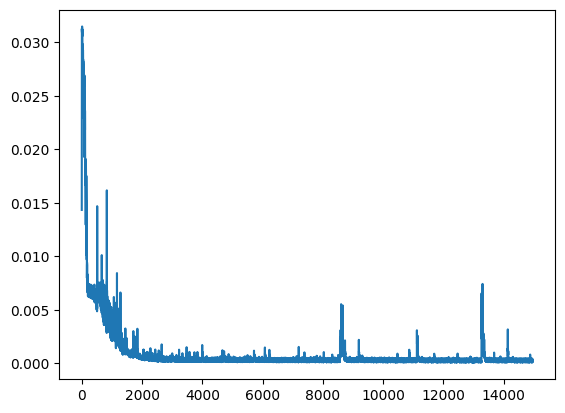

In [33]:
import matplotlib.pyplot as plt

# Plot the losses over training
plt.plot(list(range(len(idm_losses))), idm_losses, label='IDM')
plt.show()

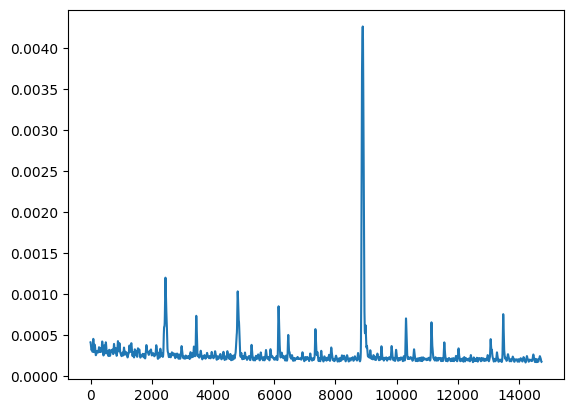

In [11]:
from scipy.ndimage import gaussian_filter1d

# plot the average reward per episode
idm_losses_averaged = gaussian_filter1d(idm_losses[3000:], sigma=10)
plt.plot(idm_losses_averaged)

Let' compare our trained IDM against the null idm (predicts 0 for all values):

In [35]:
obs_batch = idm_train_data

obs_tensor = obs_batch_to_tensor(obs_batch, device)
s0_tensor = state_batch_to_tensor([s0 for s0, _ in obs_batch], device)
s1_tensor = state_batch_to_tensor([s1 for _, s1 in obs_batch], device)
with torch.no_grad():
    action_pred = idm(obs_tensor)
    s1_pred = mm(s0_tensor, action_pred)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0].cpu().detach().numpy()
loss_y = loss[:, 1].cpu().detach().numpy()
loss_theta = loss[:, 2].cpu().detach().numpy()

print("training loss", loss.mean().item())

training loss 0.0001842722704168409


In [34]:
obs_batch = idm_validation_data

obs_tensor = obs_batch_to_tensor(obs_batch, device)
s0_tensor = state_batch_to_tensor([s0 for s0, _ in obs_batch], device)
s1_tensor = state_batch_to_tensor([s1 for _, s1 in obs_batch], device)
with torch.no_grad():
    action_pred = idm(obs_tensor)
    s1_pred = mm(s0_tensor, action_pred)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0].cpu().detach().numpy()
loss_y = loss[:, 1].cpu().detach().numpy()
loss_theta = loss[:, 2].cpu().detach().numpy()

print("validation loss", loss.mean().item())

validation loss 0.00018000061390921474


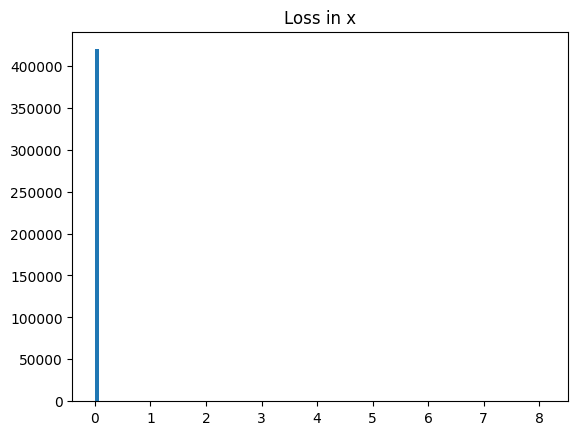

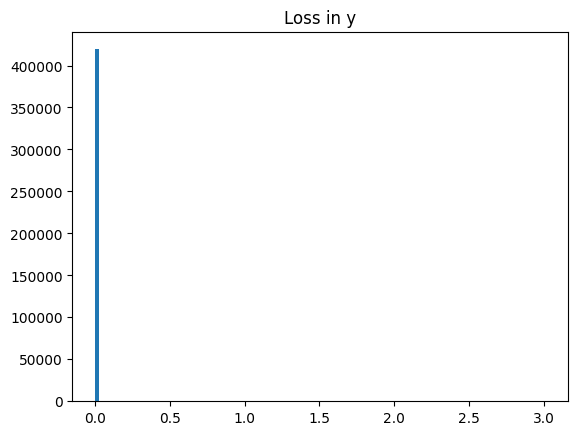

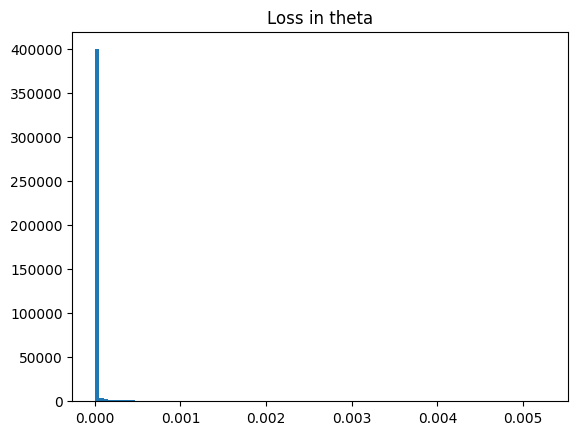

In [36]:
plt.hist(loss_x, bins=100)
plt.title('Loss in x')
plt.show()
plt.hist(loss_y, bins=100)
plt.title('Loss in y')
plt.show()
plt.hist(loss_theta, bins=100)
plt.title('Loss in theta')
plt.show()


In [37]:
# get outlier indexes
outlier_indexes = np.where((loss_x > 0.1) | (loss_y > 0.1) | (loss_theta > 0.1))[0]

print("outlier indexes", outlier_indexes)

outlier indexes [   880   2551   3668   3702   7346   8053   8238   9756  10362  11877
  13668  15632  15646  16284  16487  17660  18842  19433  21794  21989
  23477  23552  27631  28869  32060  33582  34360  36350  39046  40283
  41290  44980  46319  48135  49830  55267  59420  59820  61687  64996
  65605  65641  67059  69272  71487  74720  77631  77643  79308  81194
  81619  82710  86872  90373  91294  94923  96160  96913 100826 102436
 103135 103520 106912 108239 108717 111044 112397 113504 114897 116222
 117271 118874 118917 119648 125394 126161 126684 128037 129405 129729
 130552 130633 131343 131660 132907 133856 134600 136820 137902 138749
 139996 140653 140992 141702 145097 145243 146210 152537 153596 153829
 154142 155454 157268 157276 158942 159504 160349 160408 161262 162881
 163824 164603 168991 171030 173953 174770 175035 177161 179167 179457
 179897 180190 180450 180534 181054 182379 184052 184373 187362 188206
 189023 191257 191912 193186 193438 194830 195760 195976 1970

In [38]:
for i in outlier_indexes:
    print("outlier", i)
    print("s0", s0_tensor[i])
    print("s1", s1_tensor[i])
    print("s1_pred", s1_pred[i])
    print("action_pred", action_pred[i])

outlier 880
s0 tensor([ 5.0135e-02, -2.0834e+01,  5.0304e-03, -9.9999e-01], device='cuda:0')
s1 tensor([ 5.9085e-02, -1.8863e+01,  5.3442e-03, -9.9999e-01], device='cuda:0')
s1_pred tensor([ 6.6805e-02, -1.9886e+01,  1.1928e-03, -9.9831e-01], device='cuda:0')
action_pred tensor([-0.0237, -1.0000], device='cuda:0')
outlier 2551
s0 tensor([-9.5613e-02, -1.7687e+01, -4.6981e-03, -9.9999e-01], device='cuda:0')
s1 tensor([-1.2895e-01, -1.8623e+01, -5.8487e-03, -9.9998e-01], device='cuda:0')
s1_pred tensor([-1.1749e-01, -1.7970e+01, -5.5349e-03, -9.9877e-01], device='cuda:0')
action_pred tensor([-0.0190,  1.0000], device='cuda:0')
outlier 3668
s0 tensor([ 9.8237, -1.7501,  0.9837, -0.1799], device='cuda:0')
s1 tensor([10.4430, -1.7891,  0.9847, -0.1741], device='cuda:0')
s1_pred tensor([10.0834, -1.7453,  0.9837, -0.1766], device='cuda:0')
action_pred tensor([0.0459, 1.0000], device='cuda:0')
outlier 3702
s0 tensor([-2.9076e-02, -1.4241e+01, -1.1508e-03, -1.0000e+00], device='cuda:0')
s1 ten

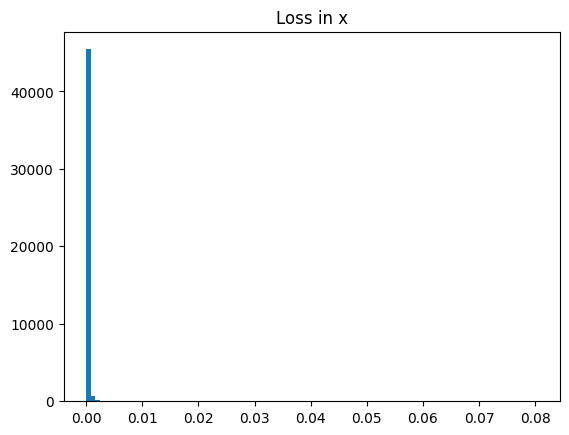

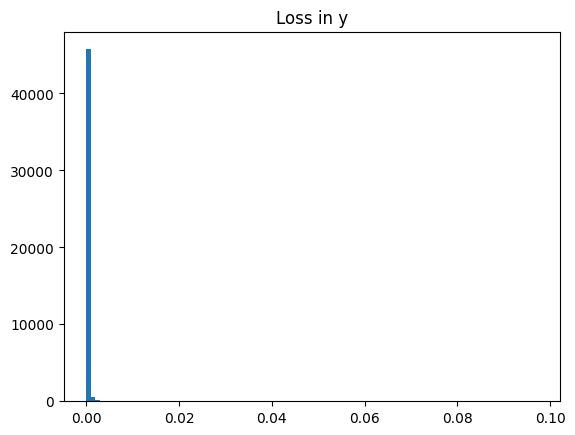

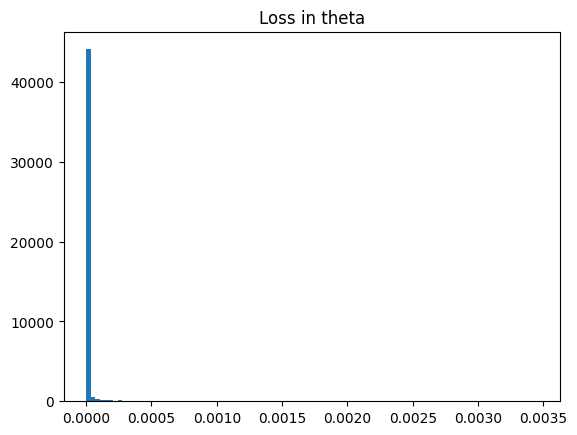

In [17]:
loss_x_no_outliers = np.array([x for x in loss_x if x < 0.1 ]) 
loss_y_no_outliers = np.array([x for x in loss_y if x < 0.1 ])
loss_theta_no_outliers = np.array([x for x in loss_theta if x < 0.1 ])

plt.hist(loss_x_no_outliers, bins=100)
plt.title('Loss in x')
plt.show()
plt.hist(loss_y_no_outliers, bins=100)
plt.title('Loss in y')
plt.show()
plt.hist(loss_theta_no_outliers, bins=100)
plt.title('Loss in theta')
plt.show()


Let's try visualizing our IDM by having it follow a track from start to finish.

In [18]:
class IDMPolicy:
    def __init__(self, net: InverseDynamicsModel):
        self.net = net

    def __call__(self, obs:Observation) -> Action:
        # sample an action from the policy network
        obs_tensor = obs_batch_to_tensor([obs], deviceof(self.net))
        # sample an action from the policy network
        with torch.no_grad():
            steering, throttle = self.net(obs_tensor)[0]
        return steering.item(), throttle.item()


### Trajectory Replay

In [20]:
scenarios = extract_scenarios_file(getFiles(WAYMO_DATA_PATH)[0])

2023-09-02 13:04:02.065223: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-02 13:04:02.086244: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-02 13:04:02.086486: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [69]:
scenario = scenarios[2]
trajectory = trajectories[2]

# reset
env = InMemoryScenarioEnv(config={"use_render": True, "manual_control": False}, s=scenario)

In [71]:
env.reset()
# set the initial state
for i in range(len(trajectory)):
    st = trajectory[i]
    env.vehicle.set_position(scenario.tracks[scenario.ego_track_index].states[i].position)
    env.vehicle.set_velocity(st.velocity)
    env.vehicle.set_heading_theta(st.heading)
    env.step([0, 0])

97
{'64': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f7ca43cdb90>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '65': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f7ca302e1d0>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '66': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f7ca302cd10>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '67': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f7ca302c650>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '68': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f7ca302c090>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '69': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f7ca302e9d0>, entry

### Closed Loop IDM

In [73]:
with torch.no_grad():
    # reset
    env.reset()

    st = trajectory[0]

    # set the initial state
    env.vehicle.set_velocity(st.velocity)
    env.vehicle.set_heading_theta(st.heading)


    for i in range(len(trajectory)-1):
        st0 = trajectory[i]
        st1 = trajectory[i+1]
        st0_pred = get_metadrive_state(env)
        action = IDMPolicy(idm)((st0_pred, st1))
        env.step(action)
        st1_pred = get_metadrive_state(env)
        print(action)
        print(st1_pred.velocity, st1_pred.heading, st1.velocity, st1.heading)
        

97
{'64': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f7ca4486b10>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '65': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f7ca4486150>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '66': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f7ca4487fd0>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '67': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f7ca4487510>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '68': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f7ca27a1d10>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '69': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f7ca27a1d90>, entry

### Open Loop IDM

In [75]:
with torch.no_grad():
    # reset
    env.reset()
    st = trajectory[0]

    # set the initial state
    env.vehicle.set_velocity(st.velocity)
    env.vehicle.set_heading_theta(st.heading)


    for i in range(len(trajectory)-1):
        st0 = trajectory[i]
        st1 = trajectory[i+1]
        action = IDMPolicy(idm)((st0, st1))
        env.step(action)
        st1_pred = get_metadrive_state(env)
        print(action)
        print(st1_pred.velocity, st1_pred.heading, st1.velocity, st1.heading)
        

97
{'64': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f7cecb5c090>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '65': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f7cecb5fcd0>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '66': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f7cecb5ea50>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '67': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f7cecb5f610>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '68': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f7cecb5d6d0>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '69': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f7cecb5c1d0>, entry

In [76]:
env.close()

In [27]:
env = MetaDriveEnv(config={"on_continuous_line_done": False, "use_render": False})

[INFO] MetaDrive version: 0.4.1.2
[INFO] Sensors: []
[INFO] Render Mode: none


In [42]:
def compute_loss(s_pred: State, s_true:State) -> float:
    """
    Computes the loss between the predicted state and the true state
    """
    vel_error = np.linalg.norm(s_pred.velocity - s_true.velocity) ** 2
    heading_error = normalize_angle(s_pred.heading - s_true.heading) ** 2
    return float(vel_error + heading_error)


def run_game(env: MetaDriveEnv, policy:typing.Callable[[Observation], Action], o: Observation) -> tuple[Action, float, State]:
    s0, s1 = o
    a = policy(o)
    s1_pred = next_state(env, s0, a)
    r = -compute_loss(s1, s1_pred)
    return a, r, s1_pred

def run_game_est(mm:MetadriveModel, policy:typing.Callable[[Observation], Action], o: Observation) -> tuple[Action, float, State]:
    device = deviceof(mm)
    s0, s1 = o
    a = policy(o)
    with torch.no_grad():
        s1_pred_tensor = mm(state_batch_to_tensor([s0],device), action_batch_to_tensor([a],device)).detach().cpu().numpy()[0]
    s1_pred = State(velocity=s1_pred_tensor[:2], heading=np.arctan2(s1_pred_tensor[3], s1_pred_tensor[2]))
    r = -compute_loss(s1, s1_pred)
    return a, r, s1_pred


In [40]:
import random
random.seed(42)
idm_test_set = random.sample(idm_train_data, 500)

In [41]:
def null_policy(_:Observation) -> tuple[float, float]:
    return 0, 0

# test loss function
do_nothing_loss = []
for s0, s1 in idm_test_set:
    _, rew, _ = run_game(env, null_policy, (s0, s1))
    do_nothing_loss.append(rew)

plt.title("Loss for doing nothing (simulated)")
plt.hist(do_nothing_loss, bins=200)
plt.show()
print("mean", np.mean(do_nothing_loss))
print("median", np.median(do_nothing_loss))

NameError: name 'run_game' is not defined

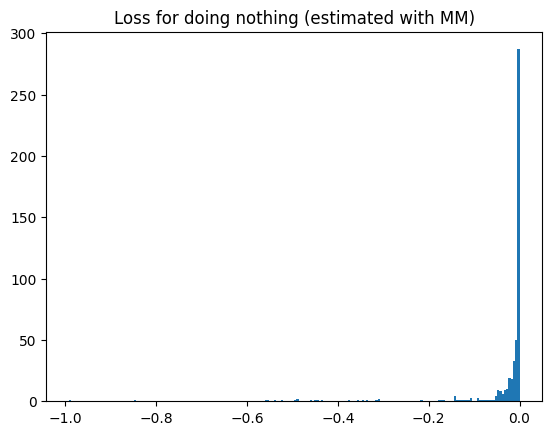

mean -0.03248267867267947
median -0.0024841805832337277


In [43]:
# test loss function
do_nothing_loss_est = []
for s0, s1 in idm_test_set:
    _, rew, pred_s1 = run_game_est(mm, null_policy, (s0, s1))
    do_nothing_loss_est.append(rew)

plt.title("Loss for doing nothing (estimated with MM)")
plt.hist(do_nothing_loss_est, bins=200)
plt.show()
print("mean", np.mean(do_nothing_loss_est))
print("median", np.median(do_nothing_loss_est))

In [45]:
# test loss function
idm_loss = []
for s0, s1 in idm_test_set:
    _, rew, _ = run_game(env, IDMPolicy(idm), (s0, s1))
    idm_loss.append(rew)

plt.title("Loss for IDM policy (simulated)")
plt.hist(idm_loss, bins=200)
plt.show()
print("mean", np.mean(idm_loss))
print("median", np.median(idm_loss))

178
{'98': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f8053dc11d0>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '100': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f8049fe72d0>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '101': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f7fec39c790>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '102': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f80448f3c10>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '103': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f804d95bcd0>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '105': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f80429f58d0>,

KeyboardInterrupt: 

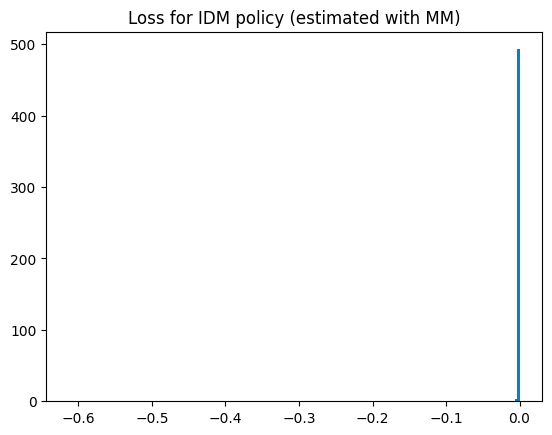

mean -0.0022925765412824704
median -2.711417282794202e-05


In [44]:
# test loss function
idm_loss_est = []
for s0, s1 in idm_test_set:
    _, rew, _ = run_game_est(mm, IDMPolicy(idm), (s0, s1))
    idm_loss_est.append(rew)

plt.title("Loss for IDM policy (estimated with MM)")
plt.hist(idm_loss_est, bins=200)
plt.show()
print("mean", np.mean(idm_loss_est))
print("median", np.median(idm_loss_est))

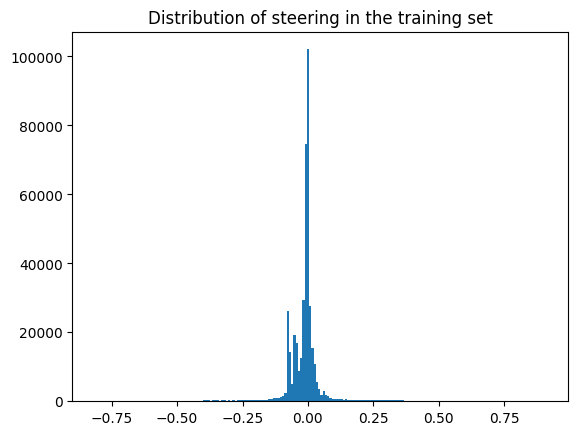

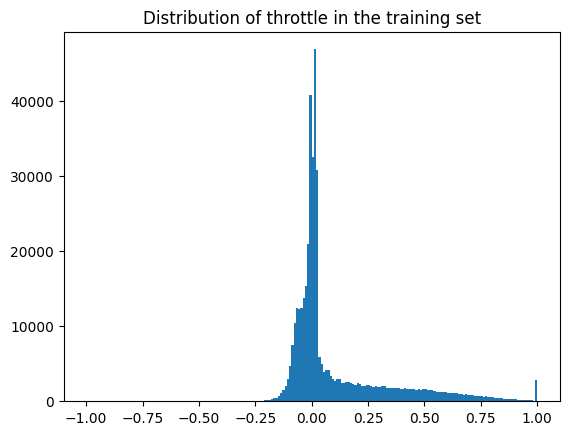

In [39]:
plt.title("Distribution of steering in the training set")
plt.hist(action_pred[:, 0].cpu().detach().numpy(), bins=200)
plt.show()

plt.title("Distribution of throttle in the training set")
plt.hist(action_pred[:, 1].cpu().detach().numpy(), bins=200)
plt.show()